## Image Classification with Deep Learning ##

## Data Preprocessing 

In [26]:
#Importing the necessary libraries 
import os
import shutil
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from PIL import Image
import warnings
import cv2
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [27]:
# Set the path to the dataset
dataset_dir = 'E:/Data Science Phase 4/Project/archive (2)'

# Set the image dimensions and number of classes
image_size = (150, 150)
num_classes = 2

In [28]:
# Load the dataset
normal_images_dir = os.path.join(dataset_dir, 'chest_xray', 'val', 'NORMAL')
pneumonia_images_dir = os.path.join(dataset_dir, 'chest_xray', 'val', 'PNEUMONIA')

In [29]:
normal_images = []
pneumonia_images = []

for filename in os.listdir(normal_images_dir):
    img = cv2.imread(os.path.join(normal_images_dir, filename))
    img = cv2.resize(img, image_size)
    normal_images.append(img)

for filename in os.listdir(pneumonia_images_dir):
    img = cv2.imread(os.path.join(pneumonia_images_dir, filename))
    img = cv2.resize(img, image_size)
    pneumonia_images.append(img)

# Create the labels for the images
normal_labels = np.zeros(len(normal_images))
pneumonia_labels = np.ones(len(pneumonia_images))

## Exploratory Data Analysis ##

In [30]:
data_dir = 'archive (2)/chest_xray/train'
normal_dir = os.path.join(data_dir, 'NORMAL')
pneumonia_dir = os.path.join(data_dir, 'PNEUMONIA')

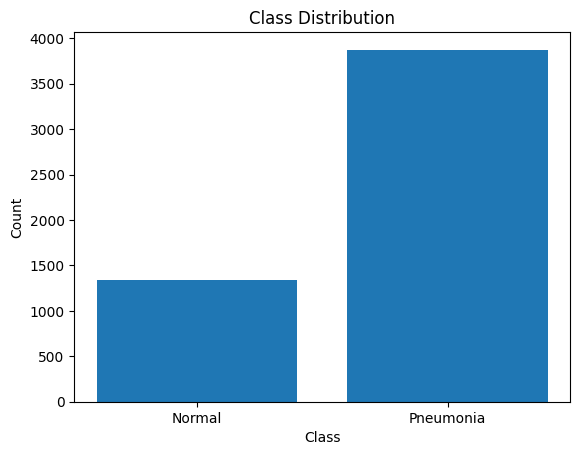

In [31]:
# Class Distribution
num_normal = len(os.listdir(normal_dir))
num_pneumonia = len(os.listdir(pneumonia_dir))

# Bar chart for class distribution
labels = ['Normal', 'Pneumonia']
counts = [num_normal, num_pneumonia]
plt.bar(labels, counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

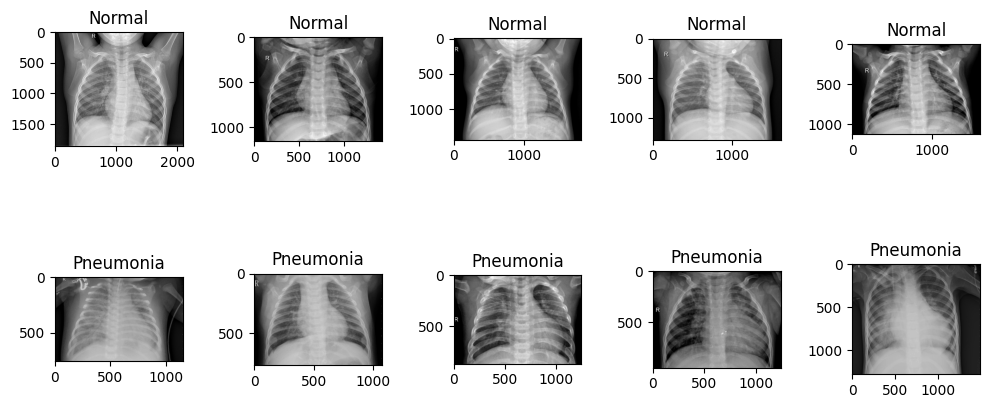

In [32]:
# Image Visualization
sample_normal_images = os.listdir(normal_dir)[:5]
sample_pneumonia_images = os.listdir(pneumonia_dir)[:5]

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()

for i in range(5):
    # Normal Images
    img = Image.open(os.path.join(normal_dir, sample_normal_images[i]))
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title('Normal')

    # Pneumonia Images
    img = Image.open(os.path.join(pneumonia_dir, sample_pneumonia_images[i]))
    axes[i + 5].imshow(img, cmap='gray')
    axes[i + 5].set_title('Pneumonia')

plt.tight_layout()
plt.show()


In [33]:
# Image Statistics
img_path = os.path.join(normal_dir, sample_normal_images[0])
img = Image.open(img_path)
img_array = np.array(img)

mean_value = np.mean(img_array)
std_value = np.std(img_array)
min_value = np.min(img_array)
max_value = np.max(img_array)

print('Image Statistics:')
print('Mean:', mean_value)
print('Standard Deviation:', std_value)
print('Min Value:', min_value)
print('Max Value:', max_value)

Image Statistics:
Mean: 128.90747832983968
Standard Deviation: 62.30103035552067
Min Value: 0
Max Value: 255


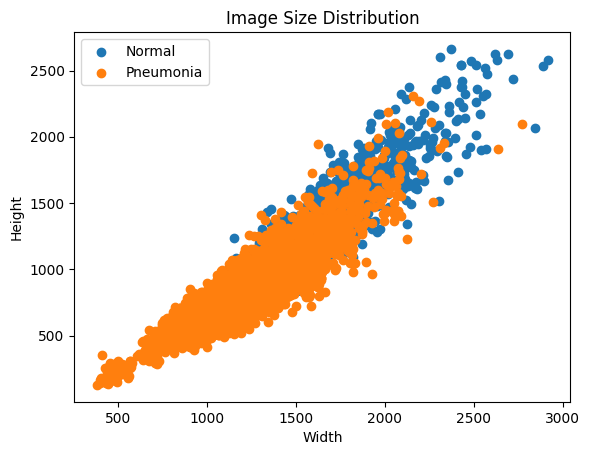

In [34]:
# Image Size Distribution
normal_image_sizes = []
pneumonia_image_sizes = []

for image_name in os.listdir(normal_dir):
    img = Image.open(os.path.join(normal_dir, image_name))
    normal_image_sizes.append(img.size)

for image_name in os.listdir(pneumonia_dir):
    img = Image.open(os.path.join(pneumonia_dir, image_name))
    pneumonia_image_sizes.append(img.size)

normal_image_sizes = np.array(normal_image_sizes)
pneumonia_image_sizes = np.array(pneumonia_image_sizes)

plt.scatter(normal_image_sizes[:, 0], normal_image_sizes[:, 1], label='Normal')
plt.scatter(pneumonia_image_sizes[:, 0], pneumonia_image_sizes[:, 1], label='Pneumonia')
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Image Size Distribution')
plt.legend()
plt.show()

## Data Augumentation

In [35]:
# Directory paths for training, validation, and testing sets
train_dir = os.path.join(dataset_dir, 'chest_xray', 'train')
val_dir = os.path.join(dataset_dir, 'chest_xray', 'val')
test_dir = os.path.join(dataset_dir, 'chest_xray', 'test')

# Create subdirectories for normal and pneumonia classes within train, val, and test directories
classes = ['NORMAL', 'PNEUMONIA']

for directory in [train_dir, val_dir, test_dir]:
    for class_name in classes:
        class_dir = os.path.join(directory, class_name)
        os.makedirs(class_dir, exist_ok=True)

# Move normal images to the train, val, and test directories
for file in os.listdir(normal_dir):
    src = os.path.join(normal_dir, file)
    if os.path.isfile(src):
        dst_train = os.path.join(train_dir, 'NORMAL', file)
        dst_val = os.path.join(val_dir, 'NORMAL', file)
        dst_test = os.path.join(test_dir, 'NORMAL', file)
        if not os.path.exists(dst_train):
            shutil.copy2(src, dst_train)
        if not os.path.exists(dst_val):
            shutil.copy2(src, dst_val)
        if not os.path.exists(dst_test):
            shutil.copy2(src, dst_test)

# Move pneumonia images to the train, val, and test directories
for file in os.listdir(pneumonia_dir):
    src = os.path.join(pneumonia_dir, file)
    if os.path.isfile(src):
        dst_train = os.path.join(train_dir, 'PNEUMONIA', file)
        dst_val = os.path.join(val_dir, 'PNEUMONIA', file)
        dst_test = os.path.join(test_dir, 'PNEUMONIA', file)
        if not os.path.exists(dst_train):
            shutil.copy2(src, dst_train)
        if not os.path.exists(dst_val):
            shutil.copy2(src, dst_val)
        if not os.path.exists(dst_test):
            shutil.copy2(src, dst_test)



In [36]:
# Set the input image dimensions
img_width, img_height = 128, 128

# Define the batch size
batch_size = 32

# Create data generators for data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

# Generate batches of augmented training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

# Generate batches of validation data
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# Generate batches of testing data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.
Found 5840 images belonging to 2 classes.


## Model Architecture

In [37]:
# Define the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Model Training 

In [38]:
# Set the desired number of epochs and other parameters
num_epochs = 3
batch_size = 32  # Specify the desired batch size

# Define the image dimensions
img_width, img_height = 150, 150

# Create data generators with specified batch size
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# Define your model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=num_epochs,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size
)

# Evaluate the model on the test set
test_steps_per_epoch = test_generator.n // batch_size
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps_per_epoch)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Found 5216 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.
Found 5840 images belonging to 2 classes.
Epoch 1/3
163/163 [==============================] - 141s 862ms/step - loss: 0.2823 - accuracy: 0.8748 - val_loss: 0.1155 - val_accuracy: 0.9565
Epoch 2/3
163/163 [==============================] - 136s 834ms/step - loss: 0.1099 - accuracy: 0.9590 - val_loss: 0.1291 - val_accuracy: 0.9521
Epoch 3/3
182/182 [==============================] - 109s 597ms/step - loss: 0.1371 - accuracy: 0.9615
Test Loss: 0.13706161081790924
Test Accuracy: 0.9615384340286255


## Model Evaluation

In [39]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // test_generator.batch_size)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

182/182 [==============================] - 58s 314ms/step - loss: 0.1371 - accuracy: 0.9615
Test Loss: 0.13706161081790924
Test Accuracy: 0.9615384340286255


## Visualization

In [42]:
# Set the desired number of epochs and other parameters
num_epochs = 3
train_steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps_per_epoch = val_generator.n // val_generator.batch_size

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=num_epochs,
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch
)

Epoch 1/3
163/163 [==============================] - 157s 964ms/step - loss: 0.0715 - accuracy: 0.9732 - val_loss: 0.0660 - val_accuracy: 0.9760
Epoch 2/3
163/163 [==============================] - 159s 976ms/step - loss: 0.0579 - accuracy: 0.9791 - val_loss: 0.0368 - val_accuracy: 0.9881
Epoch 3/3
163/163 [==============================] - 189s 1s/step - loss: 0.0547 - accuracy: 0.9789 - val_loss: 0.0372 - val_accuracy: 0.9864


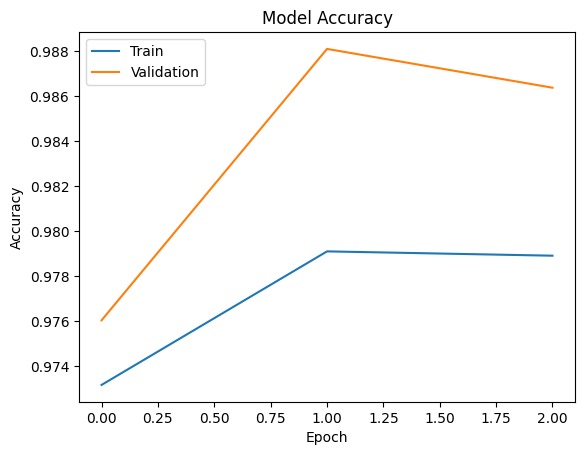

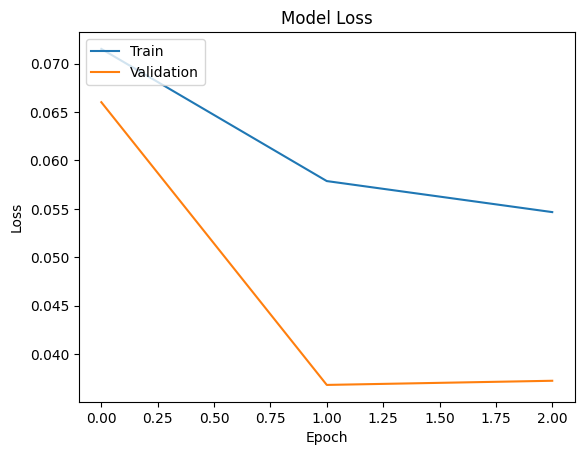

In [43]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Fine Tuning

In [44]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps_per_epoch)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

182/182 [==============================] - 57s 313ms/step - loss: 0.2115 - accuracy: 0.9621
Test Loss: 0.21152223646640778
Test Accuracy: 0.9620535969734192


## Predictions 

In [45]:
# Make predictions on the test set
predictions = model.predict(test_generator, steps=test_steps_per_epoch)

# Convert the predicted probabilities to class labels
predicted_labels = [1 if prediction > 0.5 else 0 for prediction in predictions]

# Print some example predictions
for i in range(10):
    image_path = test_generator.filepaths[i]
    true_label = test_generator.labels[i]
    predicted_label = predicted_labels[i]
    print("Image:", image_path)
    print("True Label:", true_label)
    print("Predicted Label:", predicted_label)
    print()

182/182 [==============================] - 133s 728ms/step
Image: E:/Data Science Phase 4/Project/archive (2)\chest_xray\test\NORMAL\IM-0001-0001.jpeg
True Label: 0
Predicted Label: 0

Image: E:/Data Science Phase 4/Project/archive (2)\chest_xray\test\NORMAL\IM-0003-0001.jpeg
True Label: 0
Predicted Label: 1

Image: E:/Data Science Phase 4/Project/archive (2)\chest_xray\test\NORMAL\IM-0005-0001.jpeg
True Label: 0
Predicted Label: 1

Image: E:/Data Science Phase 4/Project/archive (2)\chest_xray\test\NORMAL\IM-0006-0001.jpeg
True Label: 0
Predicted Label: 1

Image: E:/Data Science Phase 4/Project/archive (2)\chest_xray\test\NORMAL\IM-0007-0001.jpeg
True Label: 0
Predicted Label: 0

Image: E:/Data Science Phase 4/Project/archive (2)\chest_xray\test\NORMAL\IM-0009-0001.jpeg
True Label: 0
Predicted Label: 0

Image: E:/Data Science Phase 4/Project/archive (2)\chest_xray\test\NORMAL\IM-0010-0001.jpeg
True Label: 0
Predicted Label: 0

Image: E:/Data Science Phase 4/Project/archive (2)\chest_xr

In [47]:
from sklearn.metrics import confusion_matrix

# Get the model's predictions
y_pred = model.predict(test_generator)
y_pred = np.round(y_pred).flatten()

# Get the true labels
y_true = test_generator.classes

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)


183/183 [==============================] - 59s 318ms/step
Confusion Matrix:
[[1378  197]
 [  24 4241]]


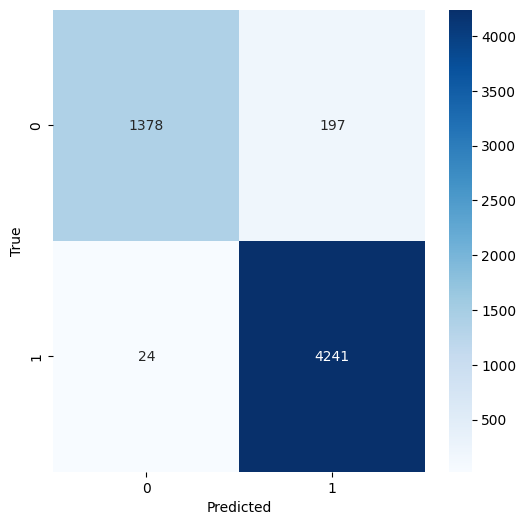

In [48]:
# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Deployment 

In [ ]:
#from flask import Flask, request, jsonify
#import tensorflow as tf

# Load the trained model
#model = tf.keras.models.load_model('path/to/your/model')

# Initialize Flask application
#app = Flask(__name__)

# Define API endpoint for model predictions
#@app.route('/predict', methods=['POST'])
#def predict():
    # Get the image file from the request
    file = request.files['file']

    # Preprocess the image
    # (Perform any necessary preprocessing steps such as resizing, normalization, etc.)
    # ...

    # Convert the image to numpy array
    img = ...  # Convert the preprocessed image to numpy array

    # Make a prediction
    prediction = model.predict(tf.expand_dims(img, axis=0))[0]
    predicted_class = 'PNEUMONIA' if prediction > 0.5 else 'NORMAL'

    # Return the prediction result as JSON
    return jsonify({'prediction': predicted_class})

#if __name__ == '__main__':
    # Run the Flask application
    app.run(host='0.0.0.0', port=5000)

IndentationError: unexpected indent (2436411133.py, line 14)